In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import matplotlib.pyplot as plt
import torch 
from torch import nn
torch.set_default_dtype(torch.float64)
import torch.nn.functional as func

import copy
from tqdm.notebook import tqdm
import time
import random
import seaborn as sns
sns.set_theme()

from sklearn.neighbors import NearestNeighbors
from scipy.interpolate import griddata
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import euclidean_distances
from IPython.display import clear_output

In [2]:
plt.rcParams['text.usetex'] = True

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import sys; sys.path.insert(1, '../')
from committor_lib.Example3 import Solvated_dimer,Model,Solver
from committor_lib.utils    import rL2,LangevinIntegrator,Metadynamics,Metadynamics_Extend

# The system

In [4]:
# n_atoms = 32; L = 64**(1/3); density is 0.5

SYS      = Solvated_dimer(n_atoms=32,L=64**(1/3),h=5,w=0.25,r0=2**(1/6),eps=1,rWCA=2**(1/6),); EPS = 1;
get_x_bc = SYS.get_X_bc
LI       = LangevinIntegrator(dim=SYS.dim)

# Read some data

In [5]:
# By simulating the Langevin dynamics
X_A,X_B = np.loadtxt('X_A'),np.loadtxt('X_B')
# By Monte Carlo methods
X_u,q_u = np.loadtxt('X_u'),np.loadtxt('q_u')
print(X_A.shape,X_B.shape,X_u.shape,q_u.shape);
def Error_Model(model): return rL2(q_u,model.get_q(X_u))
def E_AB(model): return np.sqrt(np.mean(model.get_q(X_A)**2))+np.sqrt(np.mean((1-model.get_q(X_B))**2))

(2000, 96) (2000, 96) (1574, 96) (1574,)


In [6]:
def Estimate_Model(model,X_u=X_u,q_u=q_u,SYS=SYS):
    fig,ax = plt.subplots(1,2,figsize=(12,5))
    q_NN = model.get_q(X_u)
    ax[0].scatter(SYS.get_bond_length(X_u),q_NN,s=5.,label='100 states')
    ax[1].scatter(SYS.get_bond_length(X_u),q_u,s=5.,c='g',label='100 states')
    ax[0].set_title('NN: %.3f'%rL2(q_u,q_NN))
    ax[1].set_title('MC')
    for i in range(2):
        ax[i].set_xlabel('bond length',fontsize=13)
        ax[i].set_ylabel('$q$',fontsize=13,rotation=0)
        ax[i].set_xlim([SYS.r0,SYS.r0+2*SYS.w])
        ax[i].set_ylim([-.1,1.1])
        ax[i].legend(fontsize=13)
    plt.show()

# Set the model

In [7]:
def get_wrapvec(x,L=SYS.L): return x-torch.round(x/L)*L

n           = 10
rbf_centers = torch.tensor(np.linspace(0,SYS.L/2*np.sqrt(3)+1,100)).cuda()
rbf_gap     = (rbf_centers[1]-rbf_centers[0])**2*10
model       = Model(get_wrapvec=get_wrapvec,rbf_centers=rbf_centers,rbf_gap=rbf_gap,
                    n_atoms=SYS.n_atoms,input_dim=SYS.dim,n_fea=32,n_interactions=2,n=n).cuda()
solver      = Solver(model,unit_len=100,q0=-5,q1=5)

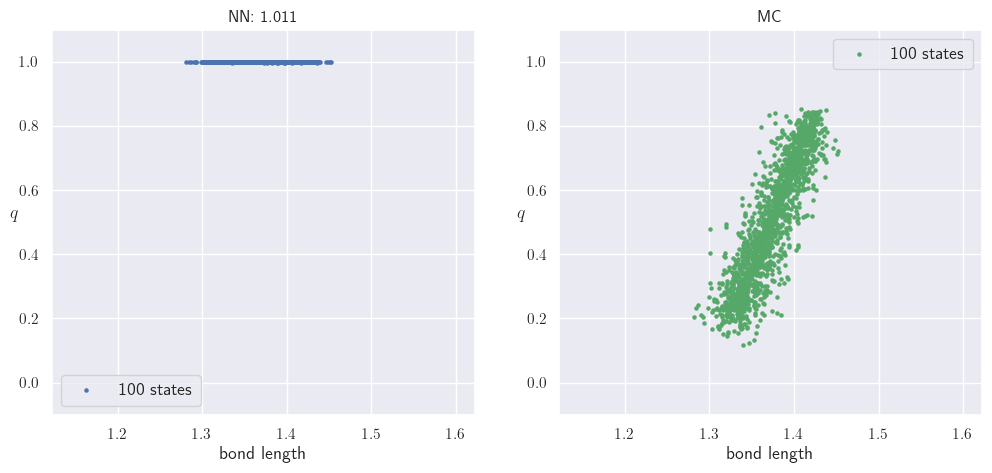

In [9]:
Estimate_Model(model,X_u=X_u,q_u=q_u,SYS=SYS)

# Train

In [10]:
def show_distr(X,ax,get_phi=SYS.get_bond_length):
    bond_length = get_phi(X)
    ax.hist(bond_length,25)
    ax.axvline(SYS.r0,linestyle='--',linewidth=3,color='r')
    ax.axvline(SYS.r0+2*SYS.w,linestyle='--',linewidth=3,color='r')
    ax.set_xlabel('bond length')
    ax.set_title('shape:'+str(X.shape))

In [11]:
def down_sample(X):
    mask = SYS.IsInA(X) | SYS.IsInB(X)
    return X[~mask]
def get_train_test(X,coef,X_A,X_B,ratio=0.7):
    Xc         = np.hstack([X,coef.reshape(-1,1)])
    data_train = []
    data_test  = []
    for d,requires_grad in [[Xc,True],[X_A,False],[X_B,False]]:
        perm = np.random.permutation(len(d))
        d1 = d[perm[:int(len(d)*ratio)]]
        data_train.append(torch.tensor(d1,requires_grad=requires_grad).cuda())
        d2 = d[perm[int(len(d)*ratio):]]
        data_test.append(torch.tensor(d2,requires_grad=requires_grad).cuda())
    return data_train,data_test 

In [12]:
NAME = 'ABC2'
if not os.path.isdir('../saved_models/'+NAME+'/'): os.mkdir('../saved_models/'+NAME+'/')
if not os.path.isdir('../meta_data/'+NAME+'/'): os.mkdir('../meta_data/'+NAME+'/')

In [13]:
def get_wrapvec(x,L=SYS.L): return x-torch.round(x/L)*L

n           = 10
rbf_centers = torch.tensor(np.linspace(0,SYS.L/2*np.sqrt(3)+1,100)).cuda()
rbf_gap     = (rbf_centers[1]-rbf_centers[0])**2*10
model       = Model(get_wrapvec=get_wrapvec,rbf_centers=rbf_centers,rbf_gap=rbf_gap,
                    n_atoms=SYS.n_atoms,input_dim=SYS.dim,n_fea=32,n_interactions=2,n=n).cuda()
solver      = Solver(model,unit_len=100,q0=-5,q1=5)

meta = Metadynamics_Extend(model=model,h=.1,w=.003,eps=EPS)

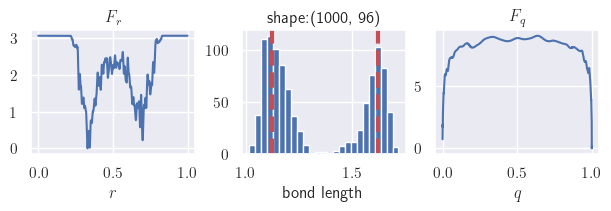

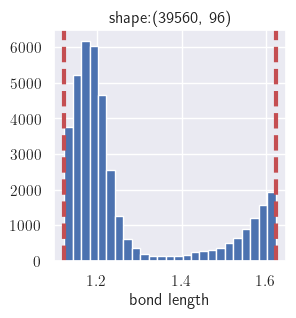

torch.Size([39164, 97]) torch.Size([396, 97])
torch.Size([1980, 96]) torch.Size([20, 96])
torch.Size([1980, 96]) torch.Size([20, 96])
 0k, Loss: -1.00000, -1.00000, Error: 0.92527 9.78e-03
 0k, Loss: -1.00000, -1.00000, Error: 0.33973 0.01960
 1k, Loss: -1.00000, -1.00000, Error: 0.32614 0.01572
 1k, Loss: -1.00000, -1.00000, Error: 0.41486 0.01547
 2k, Loss: -1.00000, -1.00000, Error: 0.36955 0.01277
 2k, Loss: -1.00000, -1.00000, Error: 0.30177 0.01299
 3k, Loss: -1.00000, -1.00000, Error: 0.41401 0.01607
 3k, Loss: -1.00000, -1.00000, Error: 0.48468 0.01301
 4k, Loss: -1.00000, -1.00000, Error: 0.28066 0.01038
 4k, Loss: -1.00000, -1.00000, Error: 0.27078 0.01086
 5k, Loss: -1.00000, -1.00000, Error: 0.42795 0.01329


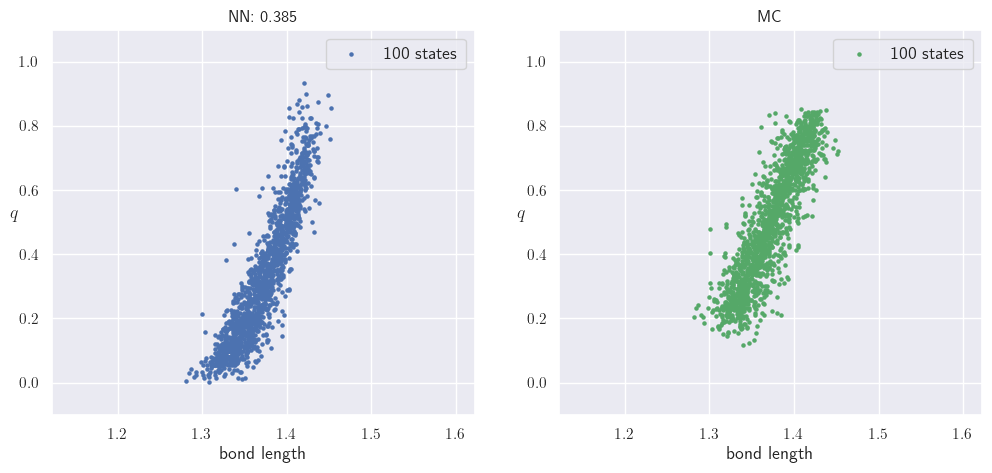

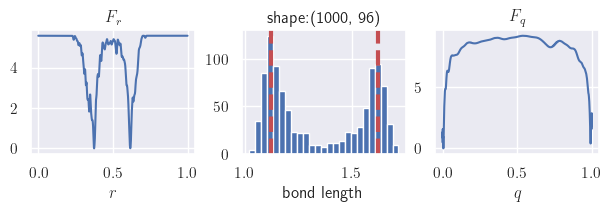

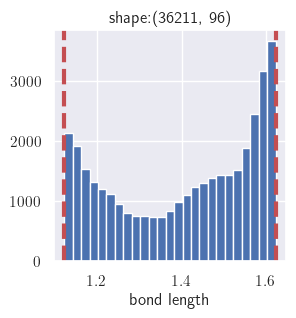

torch.Size([35848, 97]) torch.Size([363, 97])
torch.Size([1980, 96]) torch.Size([20, 96])
torch.Size([1980, 96]) torch.Size([20, 96])
 0k, Loss: -1.00000, -1.00000, Error: 0.38540 0.01268
 0k, Loss: -1.00000, -1.00000, Error: 0.21024 0.01027
 1k, Loss: -1.00000, -1.00000, Error: 0.19530 0.01040
 1k, Loss: -1.00000, -1.00000, Error: 0.18677 0.01017
 2k, Loss: -1.00000, -1.00000, Error: 0.18583 0.01014
 2k, Loss: -1.00000, -1.00000, Error: 0.19111 0.01127
 3k, Loss: -1.00000, -1.00000, Error: 0.21023 0.01017
 3k, Loss: -1.00000, -1.00000, Error: 0.17133 0.01096
 4k, Loss: -1.00000, -1.00000, Error: 0.15954 0.01066
 4k, Loss: -1.00000, -1.00000, Error: 0.15545 0.01087
 5k, Loss: -1.00000, -1.00000, Error: 0.16968 0.01073


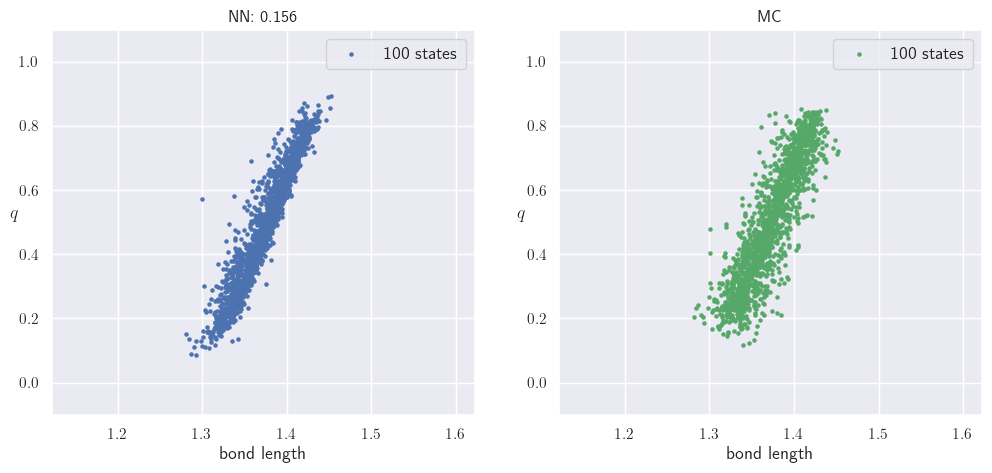

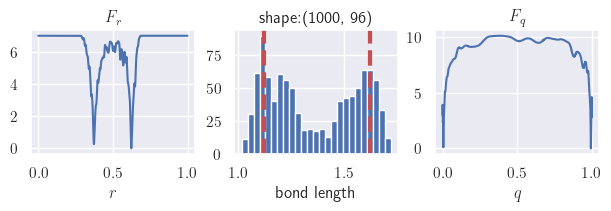

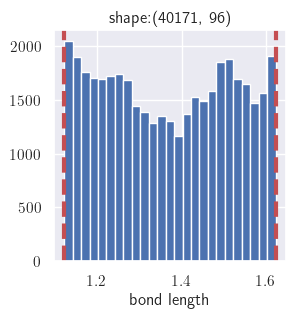

torch.Size([39769, 97]) torch.Size([402, 97])
torch.Size([1980, 96]) torch.Size([20, 96])
torch.Size([1980, 96]) torch.Size([20, 96])
 0k, Loss: -1.00000, -1.00000, Error: 0.15595 0.01062
 0k, Loss: -1.00000, -1.00000, Error: 0.20495 0.01099
 1k, Loss: -1.00000, -1.00000, Error: 0.20477 0.01154
 1k, Loss: -1.00000, -1.00000, Error: 0.15234 0.01141
 2k, Loss: -1.00000, -1.00000, Error: 0.13741 0.01154
 2k, Loss: -1.00000, -1.00000, Error: 0.20530 0.01072
 3k, Loss: -1.00000, -1.00000, Error: 0.13343 0.01183
 3k, Loss: -1.00000, -1.00000, Error: 0.13824 0.01179
 4k, Loss: -1.00000, -1.00000, Error: 0.12169 0.01198
 4k, Loss: -1.00000, -1.00000, Error: 0.16625 0.01178
 5k, Loss: -1.00000, -1.00000, Error: 0.12128 0.01196


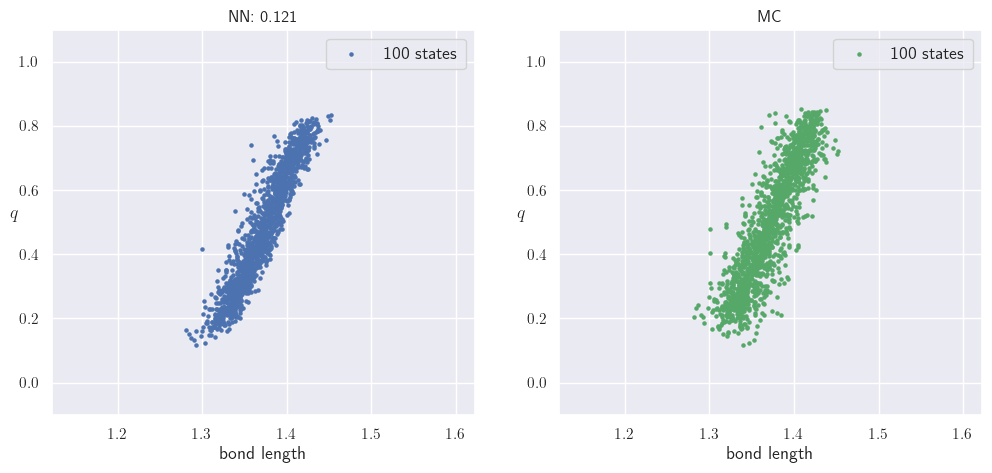

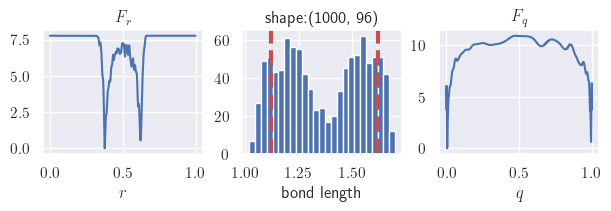

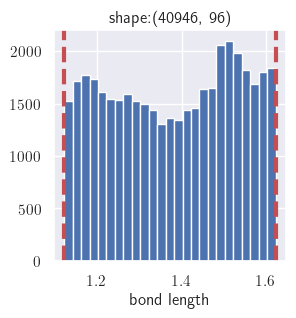

torch.Size([40536, 97]) torch.Size([410, 97])
torch.Size([1980, 96]) torch.Size([20, 96])
torch.Size([1980, 96]) torch.Size([20, 96])
 0k, Loss: -1.00000, -1.00000, Error: 0.12056 0.01197
 0k, Loss: -1.00000, -1.00000, Error: 0.12843 0.01137
 1k, Loss: -1.00000, -1.00000, Error: 0.19194 0.01225
 1k, Loss: -1.00000, -1.00000, Error: 0.11308 0.01124
 2k, Loss: -1.00000, -1.00000, Error: 0.10555 0.01152
 2k, Loss: -1.00000, -1.00000, Error: 0.10497 0.01184
 3k, Loss: -1.00000, -1.00000, Error: 0.10784 0.01221
 3k, Loss: -1.00000, -1.00000, Error: 0.10060 0.01221
 4k, Loss: -1.00000, -1.00000, Error: 0.09413 0.01188
 4k, Loss: -1.00000, -1.00000, Error: 0.09257 0.01209
 5k, Loss: -1.00000, -1.00000, Error: 0.18511 0.01226


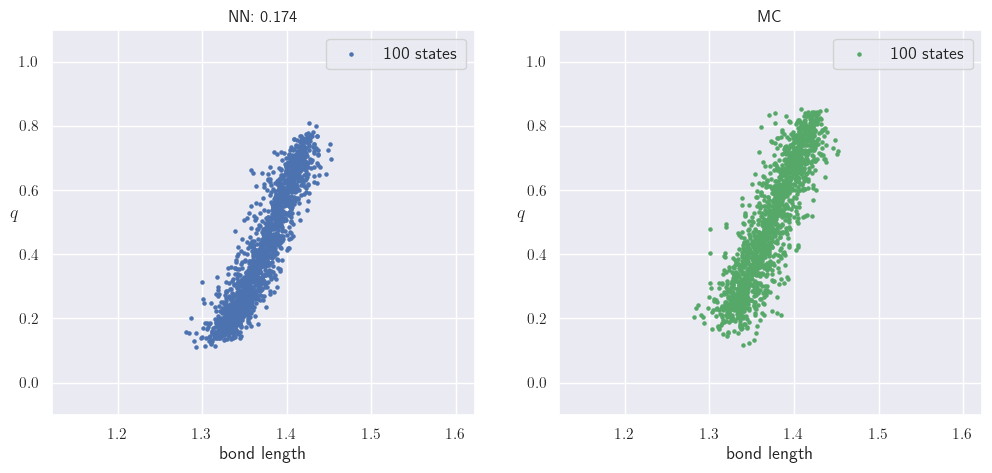

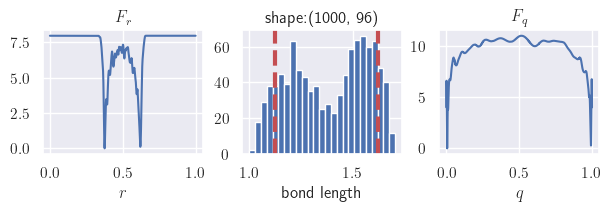

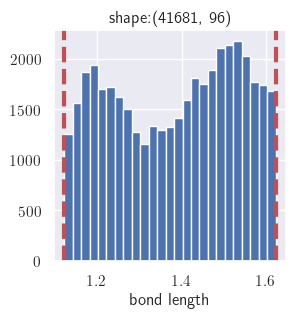

torch.Size([41264, 97]) torch.Size([417, 97])
torch.Size([1980, 96]) torch.Size([20, 96])
torch.Size([1980, 96]) torch.Size([20, 96])
 0k, Loss: -1.00000, -1.00000, Error: 0.17353 0.01221
 0k, Loss: -1.00000, -1.00000, Error: 0.09667 0.01165
 1k, Loss: -1.00000, -1.00000, Error: 0.09928 0.01170
 1k, Loss: -1.00000, -1.00000, Error: 0.09619 0.01203
 2k, Loss: -1.00000, -1.00000, Error: 0.08690 0.01149
 2k, Loss: -1.00000, -1.00000, Error: 0.09797 0.01202
 3k, Loss: -1.00000, -1.00000, Error: 0.08576 0.01191
 3k, Loss: -1.00000, -1.00000, Error: 0.09106 0.01190
 4k, Loss: -1.00000, -1.00000, Error: 0.09840 0.01219
 4k, Loss: -1.00000, -1.00000, Error: 0.08988 0.01190
 5k, Loss: -1.00000, -1.00000, Error: 0.10835 0.01137


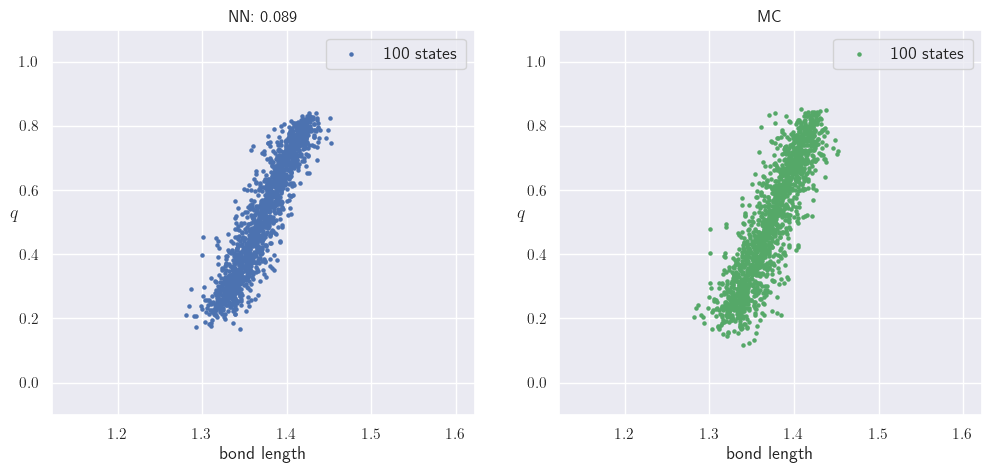

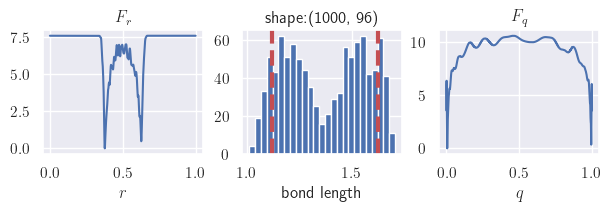

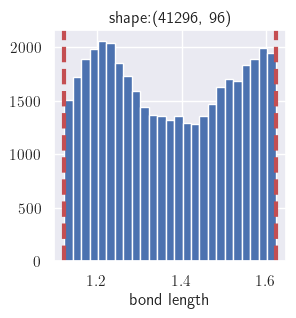

torch.Size([40883, 97]) torch.Size([413, 97])
torch.Size([1980, 96]) torch.Size([20, 96])
torch.Size([1980, 96]) torch.Size([20, 96])
 0k, Loss: -1.00000, -1.00000, Error: 0.08929 0.01138
 0k, Loss: -1.00000, -1.00000, Error: 0.08962 0.01207
 1k, Loss: -1.00000, -1.00000, Error: 0.10758 0.01178
 1k, Loss: -1.00000, -1.00000, Error: 0.17183 0.01172
 2k, Loss: -1.00000, -1.00000, Error: 0.08088 0.01206
 2k, Loss: -1.00000, -1.00000, Error: 0.09859 0.01225
 3k, Loss: -1.00000, -1.00000, Error: 0.12966 0.01242
 3k, Loss: -1.00000, -1.00000, Error: 0.10690 0.01216
 4k, Loss: -1.00000, -1.00000, Error: 0.08573 0.01166
 4k, Loss: -1.00000, -1.00000, Error: 0.16799 0.01133
 5k, Loss: -1.00000, -1.00000, Error: 0.08300 0.01218


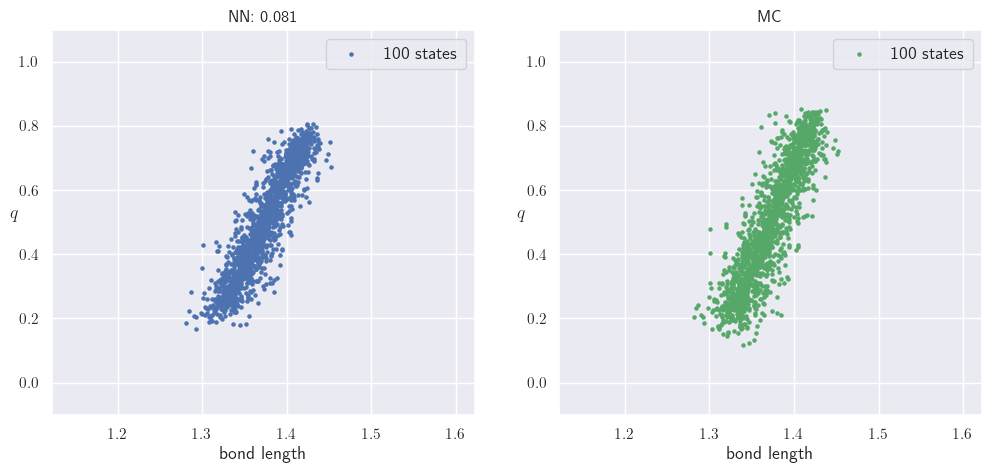

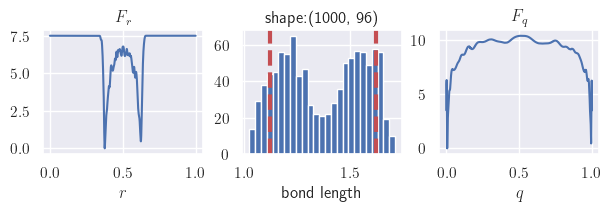

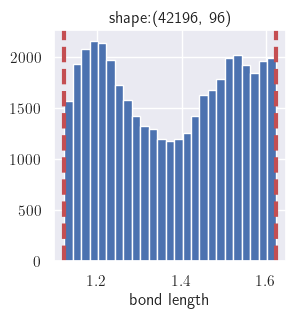

torch.Size([41774, 97]) torch.Size([422, 97])
torch.Size([1980, 96]) torch.Size([20, 96])
torch.Size([1980, 96]) torch.Size([20, 96])
 0k, Loss: -1.00000, -1.00000, Error: 0.08125 0.01213
 0k, Loss: -1.00000, -1.00000, Error: 0.07370 0.01168
 1k, Loss: -1.00000, -1.00000, Error: 0.10276 0.01207
 1k, Loss: -1.00000, -1.00000, Error: 0.08029 0.01202
 2k, Loss: -1.00000, -1.00000, Error: 0.07321 0.01176
 2k, Loss: -1.00000, -1.00000, Error: 0.07207 0.01190
 3k, Loss: -1.00000, -1.00000, Error: 0.09654 0.01205
 3k, Loss: -1.00000, -1.00000, Error: 0.10214 0.01196
 4k, Loss: -1.00000, -1.00000, Error: 0.07137 0.01185
 4k, Loss: -1.00000, -1.00000, Error: 0.07338 0.01166
 5k, Loss: -1.00000, -1.00000, Error: 0.09866 0.01166


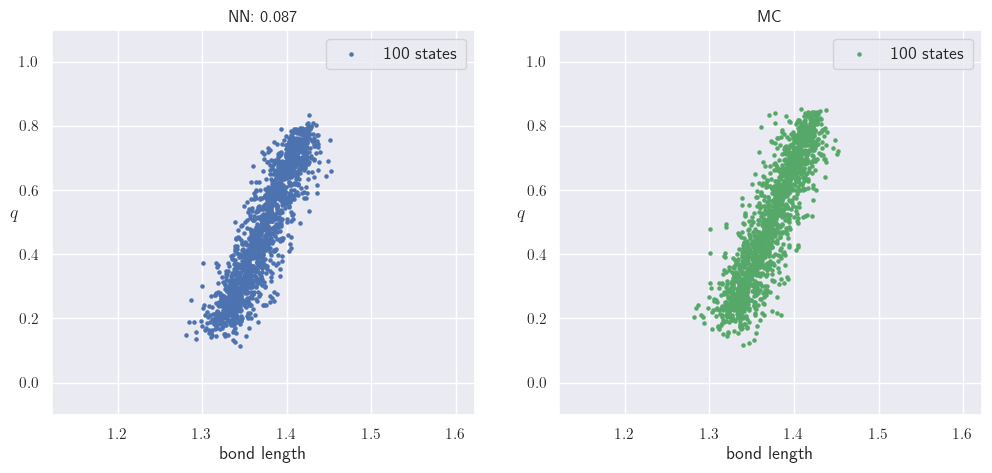

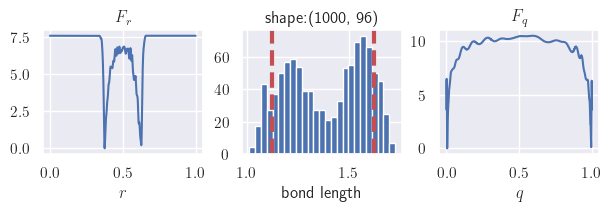

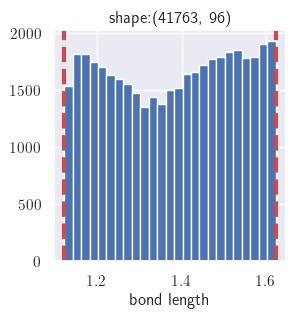

torch.Size([41345, 97]) torch.Size([418, 97])
torch.Size([1980, 96]) torch.Size([20, 96])
torch.Size([1980, 96]) torch.Size([20, 96])
 0k, Loss: -1.00000, -1.00000, Error: 0.08702 0.01159
 0k, Loss: -1.00000, -1.00000, Error: 0.10548 0.01176
 1k, Loss: -1.00000, -1.00000, Error: 0.06765 0.01147
 1k, Loss: -1.00000, -1.00000, Error: 0.10418 0.01213
 2k, Loss: -1.00000, -1.00000, Error: 0.08327 0.01202
 2k, Loss: -1.00000, -1.00000, Error: 0.07346 0.01144
 3k, Loss: -1.00000, -1.00000, Error: 0.07901 0.01215
 3k, Loss: -1.00000, -1.00000, Error: 0.09632 0.01177
 4k, Loss: -1.00000, -1.00000, Error: 0.08126 0.01190
 4k, Loss: -1.00000, -1.00000, Error: 0.06974 0.01152
 5k, Loss: -1.00000, -1.00000, Error: 0.07326 0.01190


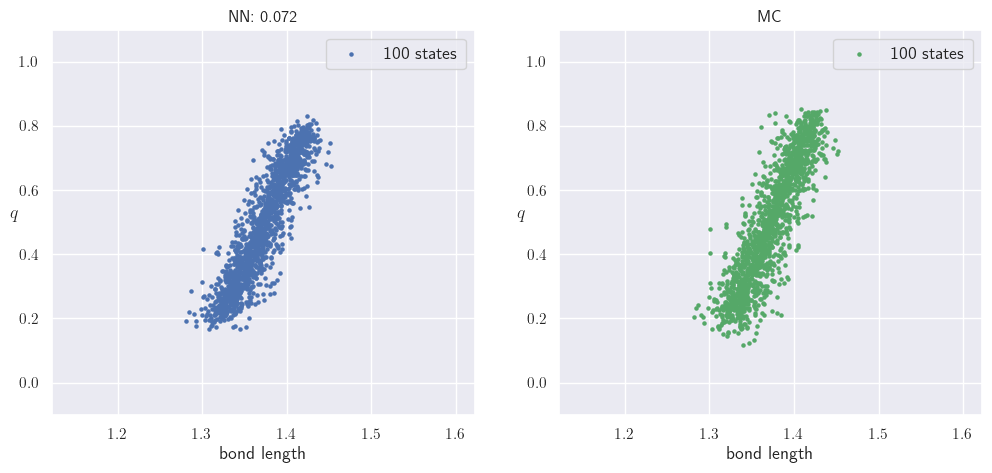

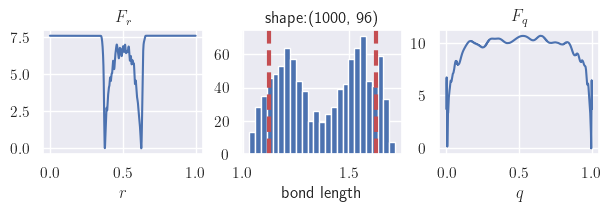

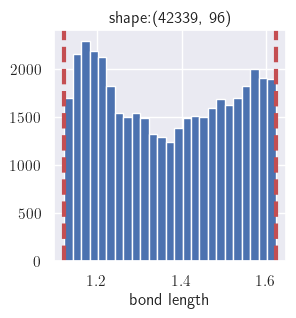

torch.Size([41915, 97]) torch.Size([424, 97])
torch.Size([1980, 96]) torch.Size([20, 96])
torch.Size([1980, 96]) torch.Size([20, 96])
 0k, Loss: -1.00000, -1.00000, Error: 0.07195 0.01190
 0k, Loss: -1.00000, -1.00000, Error: 0.08783 0.01193
 1k, Loss: -1.00000, -1.00000, Error: 0.11556 0.01152
 1k, Loss: -1.00000, -1.00000, Error: 0.06979 0.01132
 2k, Loss: -1.00000, -1.00000, Error: 0.09257 0.01189
 2k, Loss: -1.00000, -1.00000, Error: 0.06890 0.01194
 3k, Loss: -1.00000, -1.00000, Error: 0.08687 0.01202
 3k, Loss: -1.00000, -1.00000, Error: 0.07434 0.01153
 4k, Loss: -1.00000, -1.00000, Error: 0.07130 0.01187
 4k, Loss: -1.00000, -1.00000, Error: 0.07404 0.01162
 5k, Loss: -1.00000, -1.00000, Error: 0.06961 0.01179


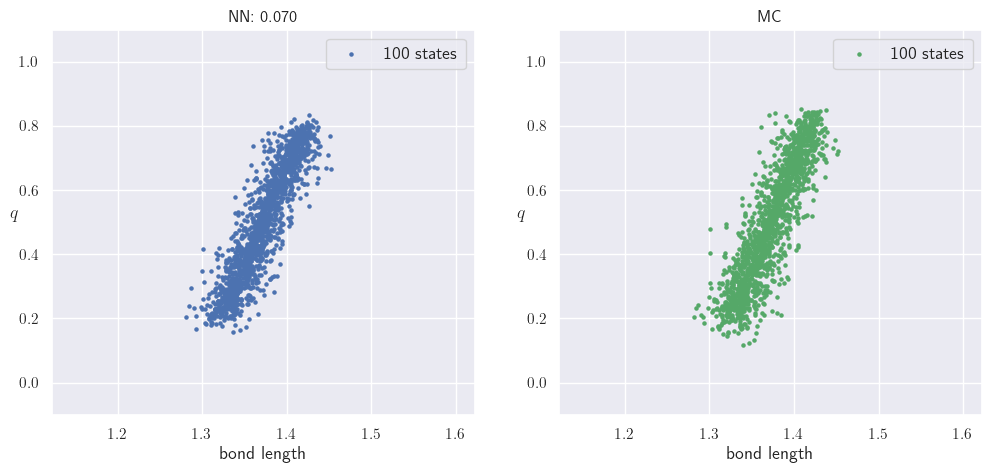

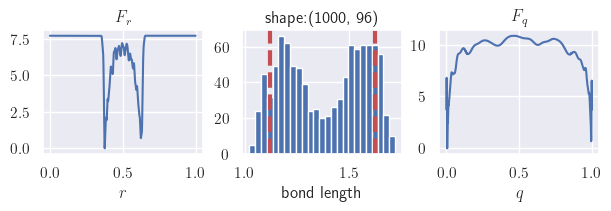

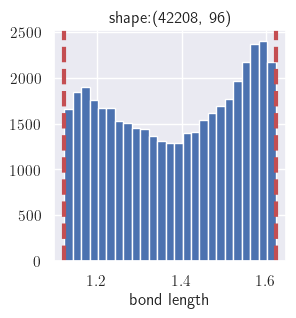

torch.Size([41785, 97]) torch.Size([423, 97])
torch.Size([1980, 96]) torch.Size([20, 96])
torch.Size([1980, 96]) torch.Size([20, 96])
 0k, Loss: -1.00000, -1.00000, Error: 0.06994 0.01185
 0k, Loss: -1.00000, -1.00000, Error: 0.08119 0.01135
 1k, Loss: -1.00000, -1.00000, Error: 0.10590 0.01149
 1k, Loss: -1.00000, -1.00000, Error: 0.07153 0.01170
 2k, Loss: -1.00000, -1.00000, Error: 0.07071 0.01191
 2k, Loss: -1.00000, -1.00000, Error: 0.07061 0.01117
 3k, Loss: -1.00000, -1.00000, Error: 0.08574 0.01160
 3k, Loss: -1.00000, -1.00000, Error: 0.06854 0.01172
 4k, Loss: -1.00000, -1.00000, Error: 0.07535 0.01149
 4k, Loss: -1.00000, -1.00000, Error: 0.07049 0.01130
 5k, Loss: -1.00000, -1.00000, Error: 0.11714 0.01159


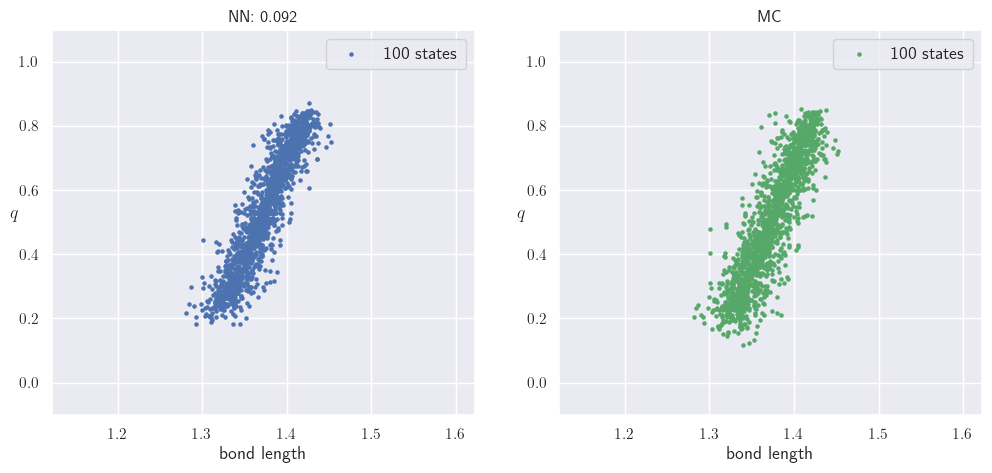

In [14]:
#########     training details  ##########################
c1 = 1;  c2 = 1; learning_rate = 1e-4;                   #
##########################################################

model.load_state_dict(torch.load('../saved_models/E3_Random1'))
torch.save(meta,'../saved_models/'+NAME+'/meta%d'%0)
torch.save(model.state_dict(), '../saved_models/'+NAME+'/par%d'%0)
    
K = 10
for k in range(1,K+1):
    
    meta.re_init()
    meta.perform(dV=SYS.get_dV,x=X_A[-1].reshape(1,-1),dt=1e-4,eps=EPS,
                 N=int(2e5),N_add=200,show_freq=.1,use_tqdm=False,get_x_bc=get_x_bc,show_distr=show_distr,
                 fig_name='../meta_data/'+NAME+'/ite%d'%k)
    meta.show_meta(show_distr)
    
    def get_f(X): return -SYS.get_dV(X) + meta.get_dF(X)/2
    X0  = np.repeat(X_A[-1].reshape(1,-1),100,axis=0)  
    X   = LI.get_data(X0,get_f,eps=EPS,dt=1e-4,m=100,T0=1,T=6,get_x_bc=get_x_bc,use_tqdm=False);
    X   = down_sample(X)
    fig,ax = plt.subplots(1,1,figsize=(3,3))
    show_distr(X,ax)
    plt.show()
    
    V_add = -meta.get_F(X)/2
    coef  = np.exp(1/EPS*(V_add-V_add.max()))
    coef  = coef/coef.mean()
    
    data_train,data_test = get_train_test(X,coef,X_A,X_B,ratio=.99)
    for i in range(len(data_train)): print(data_train[i].shape,data_test[i].shape)
    optimizer = torch.optim.Adam(model.parameters(),lr=torch.tensor(learning_rate).cuda())
    solver.train_model(data_train=data_train,data_test=data_test,c1=c1,c2=c2,batch_size=100,
                       optimizer=optimizer,n_steps=int(5000+1),n_show_loss=500,use_tqdm=False,
                       error_model1=Error_Model,error_model2=E_AB,)
    Estimate_Model(model)
    
    torch.save(meta,'../saved_models/'+NAME+'/meta%d'%k)
    torch.save([X,coef],'../meta_data/'+NAME+'/data%d'%k)
    torch.save(model.state_dict(), '../saved_models/'+NAME+'/par%d'%k)